# Analyze unlabelled telemetry data and discover abnormal machine behaviors
---

One of the biggest challenges our customers face is they do not have enough high quality data on the times when their equipment behaved abnoramally. Lack of this data has a negative impact on the performance of Amazon Lookout for Equipment. 

In this notebook, we'll address this issue head on and present an automated workflow for analyzing machine telemetry data to discover historical anomalies which improves the performance metrics across the board of Amazon Lookout for Equipment.

**Workflow:**
1. Analyze missing data
2. Analyze trends and seasonality
3. Feature preprocessing and selection
4. Feature engineering
5. Dimensionality reduction and clustering
6. Hypothesis setting and testing
7. Generating historical anomaly labels

**Note:** Before you get started, make sure you have downloaded the open source wind turbine dataset from Engie and saved it in a designated S3 path. If you haven't done this, please go through `1_data_preparation.ipynb notebook`.

### 1. Setup environment

In [2]:
%%sh
pip -q install missingno umap-learn hdbscan tsia

In [182]:
import pandas as pd
import numpy as np
import missingno as mn
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
from scipy import spatial

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
REGION_NAME = 'us-east-1'
BUCKET = 'l4e-demo'
PREFIX = 'wind-turbine'

TURBINE_ID = 'R80711'
TRAIN_DATA = f's3://{BUCKET}/{PREFIX}/training_data/{TURBINE_ID}'

### 2. Load and view data

In [6]:
df = pd.read_csv(f'{TRAIN_DATA}/telemetry.csv', index_col = 'Timestamp')
df.head()

,Q_avg,Q_min,Q_max,Q_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,...,Gb1t_max,Gb1t_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-12-31T23:00:00.000000,14.490000,-0.44,41.180000,8.190000,8.770001,6.27,11.37,0.82,9.160000,6.68,...,66.699997,0.73,39.020000,37.000000,41.000000,1.09,28.709999,28.600000,28.799999,0.03
2012-12-31T23:10:00.000000,23.700001,1.75,43.020000,8.300000,8.660000,6.01,11.37,1.02,9.120000,5.46,...,70.099998,0.92,35.919998,35.099998,37.299999,0.60,28.700001,28.600000,28.750000,0.01
2012-12-31T23:20:00.000000,25.480000,3.20,46.619999,9.479999,8.940000,6.08,11.29,0.99,9.450000,5.89,...,72.300003,0.70,36.849998,35.400002,38.400002,0.82,28.790001,28.700001,28.799999,0.03
2012-12-31T23:30:00.000000,24.379999,2.20,57.880001,11.100000,8.870000,5.96,12.15,1.14,8.979999,5.64,...,73.449997,0.62,39.750000,38.200001,41.099998,0.81,28.860001,28.799999,29.000000,0.07
2012-12-31T23:40:00.000000,14.470000,-10.88,35.189999,10.020000,9.440000,6.06,12.31,1.12,9.510000,6.10,...,71.300003,1.40,40.950001,39.599998,41.700001,0.54,28.770000,28.700001,28.900000,0.05


In [7]:
df.shape

(264673, 112)

### 3. Analyze missing values

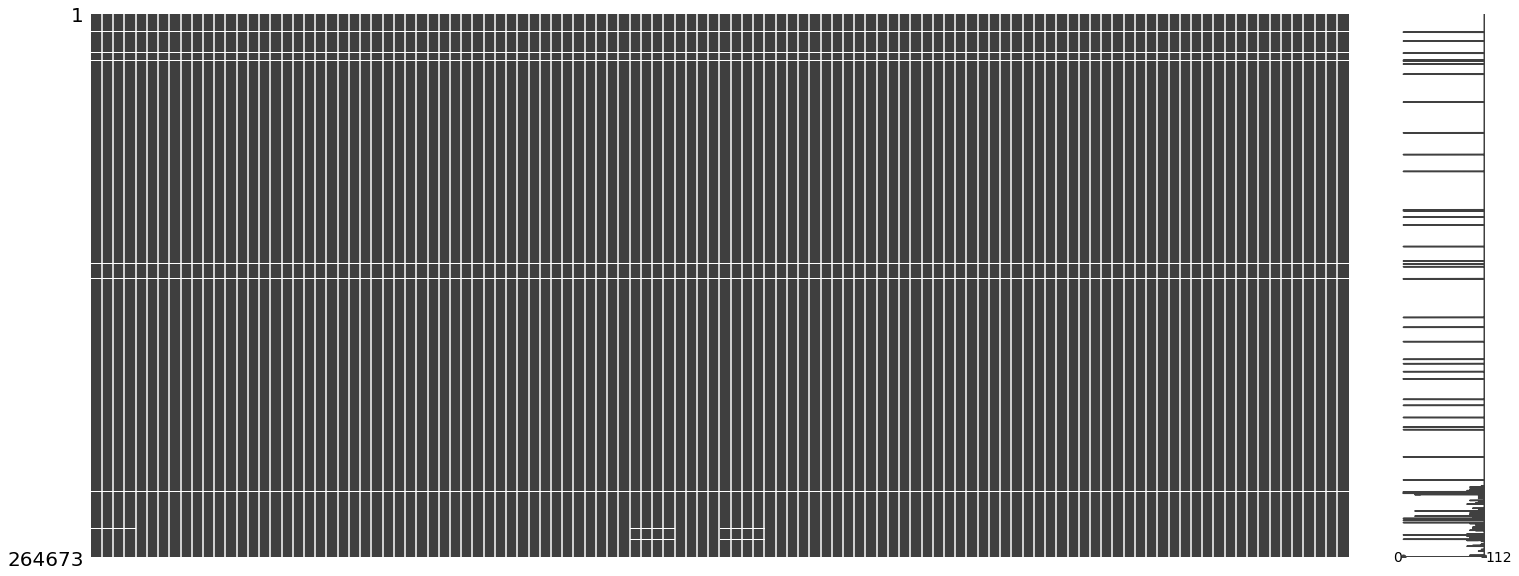

In [8]:
mn.matrix(df)
plt.show()

We see completely and partially missing rows. Let's zoom in on records that contain the missing values:

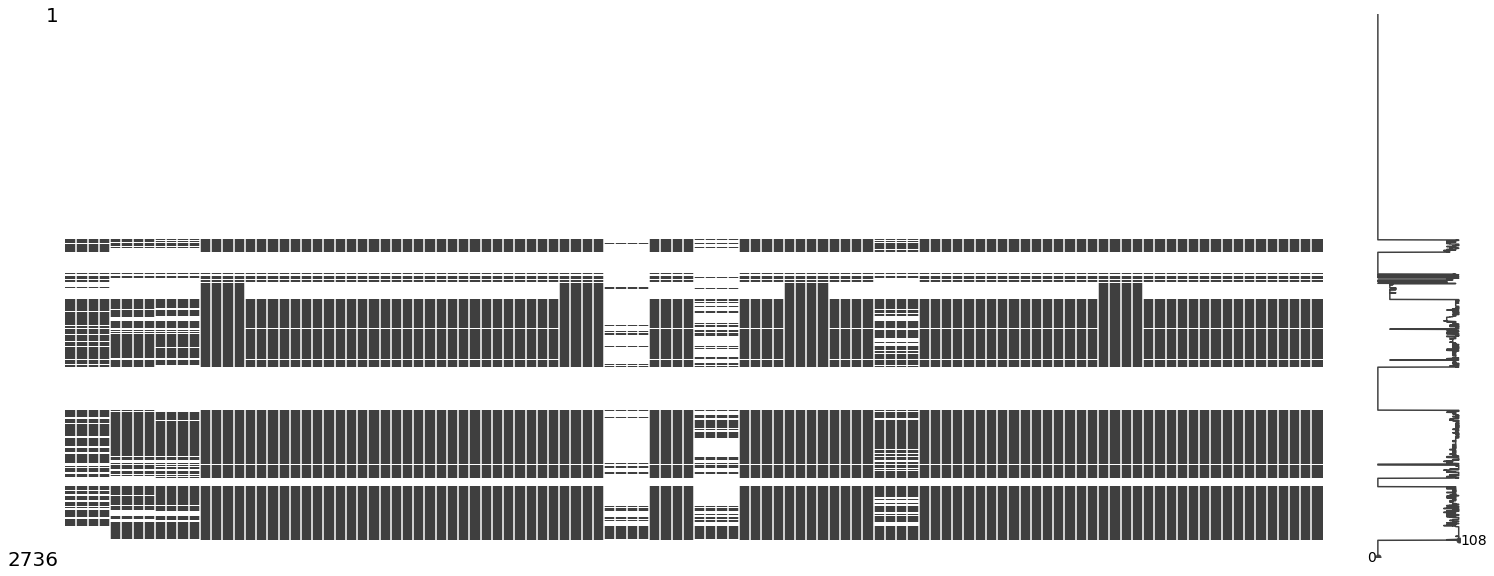

In [9]:
missing_mask = df.isnull().any(axis=1)
df_m = df.loc[missing_mask,:]
mn.matrix(df_m)
plt.show()

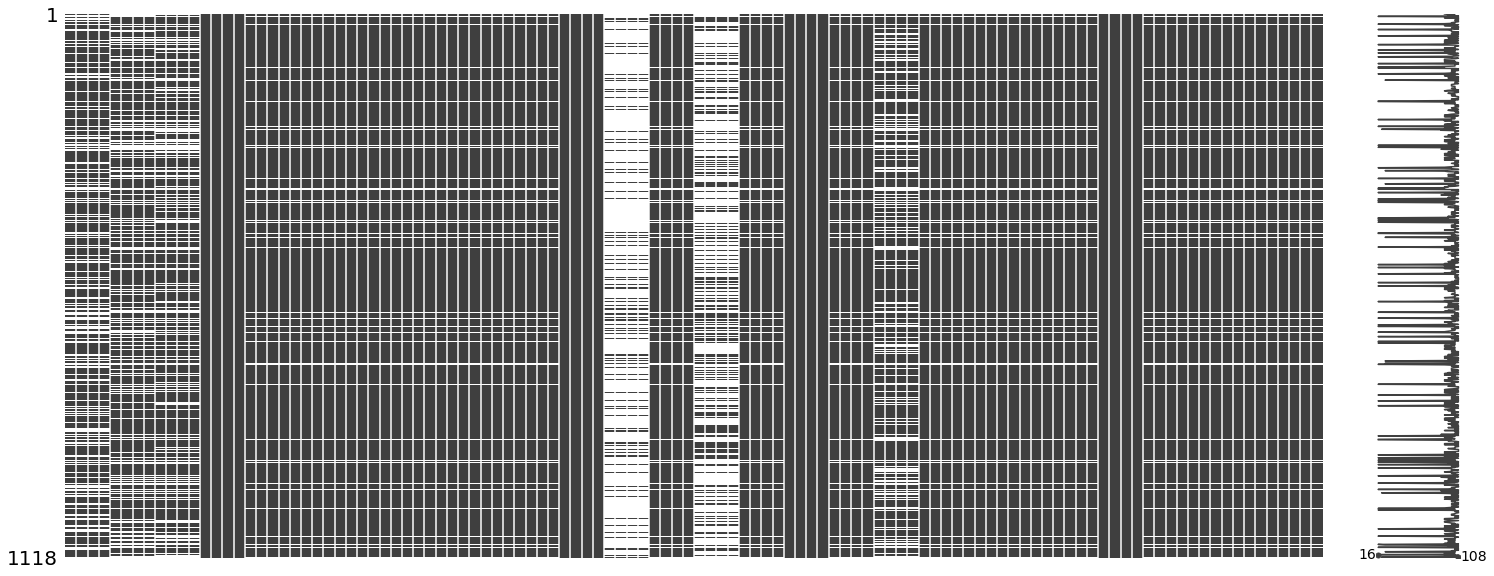

Ratio of completely missing data across rows: 0.006113203840210373
Ratio of partially missing data across rows: 0.0042240802801948064
Missing values make-up 1.034% of the rows.


In [13]:
# extract complete missing records
completely_missing_mask = df.isnull().all(axis=1)
df_cm = df.loc[completely_missing_mask,:]

# extact partially missing records
partially_missing_mask = list(set(df_m.index).difference(set(df_cm.index)))
df_pm = df.loc[partially_missing_mask,:]

# visualize partially missing records
mn.matrix(df_pm)
plt.show()

print(f'Ratio of completely missing data across rows: {df_cm.shape[0]/df.shape[0]}')
print(f'Ratio of partially missing data across rows: {df_pm.shape[0]/df.shape[0]}')
print(f'Missing values make-up {round(df_m.shape[0]/df.shape[0]*100, 3)}% of the rows.')

**In the grand scheme of things, that's not a lot of missing values!**

Now, let's run the below cell to get create a table of the time ranges when the data is missing.

In [18]:
def find_gaps(df):
    df.index = pd.to_datetime(df.index)
    is_missing = df.resample('10T').ffill(limit=1).isna().all(axis=1)
    start_idx, end_idx = [], []
    for i, row in enumerate(np.array([is_missing[:-1], is_missing[1:]]).T):
        if row[0]==False and row[1]==True:
            start_idx.append(is_missing.index[i])
        elif row[0]==True and row[1]==False:
            end_idx.append(is_missing.index[i])
        else:
            pass

    miss_df = pd.DataFrame()
    miss_df['start'] = pd.to_datetime(start_idx)
    miss_df['end'] = pd.to_datetime(end_idx)
    miss_df['duration'] = miss_df['end'] - miss_df['start'] 
    miss_df['duration (min)'] = [x.seconds/(60) for x in miss_df['duration']]
    return miss_df

gaps_df = find_gaps(df)
gaps_df.head()

,start,end,duration,duration (min)
0,2013-03-03 23:10:00,2013-03-04 23:00:00,0 days 23:50:00,1430.0
1,2013-04-03 10:10:00,2013-04-03 12:20:00,0 days 02:10:00,130.0
2,2013-05-13 22:10:00,2013-05-14 22:00:00,0 days 23:50:00,1430.0
3,2013-06-07 05:40:00,2013-06-07 05:50:00,0 days 00:10:00,10.0
4,2013-06-10 05:40:00,2013-06-10 13:10:00,0 days 07:30:00,450.0


### 4. Dimensionality reduction

In [186]:
def reduce_dimensions(df, n_components):
    df_clean = df.dropna()
    x = StandardScaler().fit_transform(df_clean)
    reducer = umap.UMAP(n_components=n_components, n_jobs=-1, metric='cosine')
    embedings = reducer.fit_transform(x)
    embedingsDf = pd.DataFrame(data = embedings
                 , columns = [f'emb-{x}' for x in range(embedings.shape[1]) ])

    embedingsDf.index = df_clean.index
    return embedingsDf.resample('10T').ffill(limit=1)

def shingle(umap_df, period):
    df_list = []
    for i in range(period):
        new_cols = [x+f'(t-{i})' for x in umap_df.columns.to_list()]
        new_df = umap_df.shift(i)
        new_df.columns = new_cols
        df_list.append(new_df)

    return pd.concat(df_list, axis=1)

umap_df_iid = reduce_dimensions(df, 2)

In [176]:
'''
period = 6*2 # 2 hour window
singled_df = shingle(umap_df_iid, period)

umap_df_ts = reduce_dimensions(singled_df, 2)
'''

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


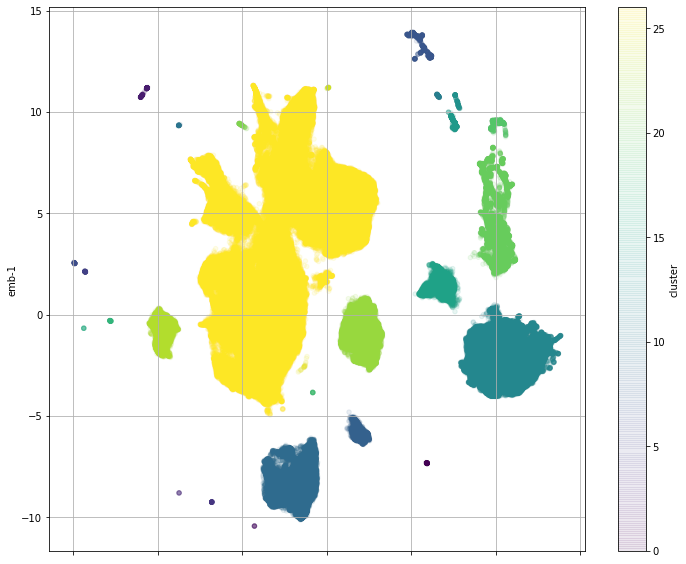

In [188]:
def cluster(df):
    df_clean = df.dropna()
    x = StandardScaler().fit_transform(df_clean)
    
    clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=-1, cluster_selection_epsilon=.1)
    clusterer.fit(x)
    
    df_clean['labels'] = clusterer.labels_
    return df_clean.resample('10T').ffill(limit=1)['labels']

umap_df_iid['cluster'] = cluster(umap_df_iid)

# Scatter plot
umap_df_iid.plot.scatter('emb-0','emb-1', c='cluster', cmap='viridis',
                        alpha=0.1, figsize=(12,10), grid=True)
plt.show()

In [192]:
umap_df_iid.head()

,emb-0,emb-1,cluster
Timestamp,,,
2012-12-31 23:00:00,6.853624,7.353701,26.0
2012-12-31 23:10:00,7.387391,6.361415,26.0
2012-12-31 23:20:00,7.767692,6.621686,26.0
2012-12-31 23:30:00,7.605279,6.376112,26.0
2012-12-31 23:40:00,7.362920,6.623297,26.0


In [193]:
def cosine_distance(t_delta, gaps_df, umap_df):
    print(f't_delta: {t_delta}')
    df_list = []
    for e in gaps_df['start']:
        e = pd.to_datetime(e)
        s = e - pd.to_timedelta(t_delta)
        df_list.append(umap_df.loc[s:e,:].dropna())
        
    df_anom = pd.concat(df_list, axis=0)
    df_anom.drop_duplicates(inplace=True)
    print(f'df_anom shape: {df_anom.shape}')
    
    a = df_anom['cluster'].value_counts()/df_anom['cluster'].value_counts().sum()
    # print(a)
    idx = a.index

    idx_b = pd.to_datetime(list(set(umap_df.index).difference(set(df_anom.index))))
    b_df = umap_df.loc[idx_b,:]

    b = b_df['cluster'].value_counts()/b_df['cluster'].value_counts().sum()
    # print(b)
    cos_dist = spatial.distance.cosine(a[idx], b[idx])
    
    print(f'a[idx]: {a[idx]}')
    print(f'b[idx]: {b[idx]}')
    return df_anom, cos_dist

cos_dist_dict = {}
for t_delta in range(20,240,10):
    t_d = f'{t_delta}T'
    df_anom, cos_dist = cosine_distance(t_d, gaps_df, umap_df_iid)
    cos_dist_dict[t_d] = {'cos_distance': cos_dist,
                          'df_anom': df_anom
                         }

t_delta: 20T
df_anom shape: (168, 3)
a[idx]: 26.0    0.267857
5.0     0.214286
6.0     0.196429
20.0    0.125000
12.0    0.101190
15.0    0.047619
9.0     0.035714
19.0    0.005952
2.0     0.005952
Name: cluster, dtype: float64
b[idx]: 26.0    0.638610
5.0     0.000160
6.0     0.000198
20.0    0.033246
12.0    0.123578
15.0    0.031972
9.0     0.072327
19.0    0.002025
2.0     0.000862
Name: cluster, dtype: float64
t_delta: 30T
df_anom shape: (218, 3)
a[idx]: 26.0    0.302752
5.0     0.174312
6.0     0.160550
20.0    0.142202
12.0    0.100917
15.0    0.050459
9.0     0.041284
2.0     0.013761
19.0    0.009174
8.0     0.004587
Name: cluster, dtype: float64
b[idx]: 26.0    0.638652
5.0     0.000153
6.0     0.000191
20.0    0.033214
12.0    0.123582
15.0    0.031967
9.0     0.072329
2.0     0.000854
19.0    0.002022
8.0     0.011123
Name: cluster, dtype: float64
t_delta: 40T
df_anom shape: (265, 3)
a[idx]: 26.0    0.332075
20.0    0.147170
5.0     0.143396
6.0     0.135849
12.0    0.10188

,cos_sim
20,0.321266
30,0.232625
40,0.172828
50,0.130625
60,0.099752


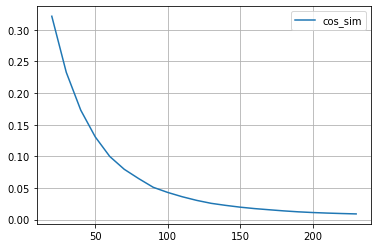

In [194]:
df_cs = pd.DataFrame()
df_cs['cos_sim'] = [cos_dist_dict[k]['cos_distance'] for k in cos_dist_dict.keys()]
df_cs.index = range(20,240,10)
display(df_cs.head())
df_cs.plot(grid=True)
plt.show()

Voila! As expected, the shorter the `anomaly` time window the bigger the `cosine` distance from the `normal`.

Now, let's take a look and see which clusters become more prevalent as we increase the `anomaly` window:

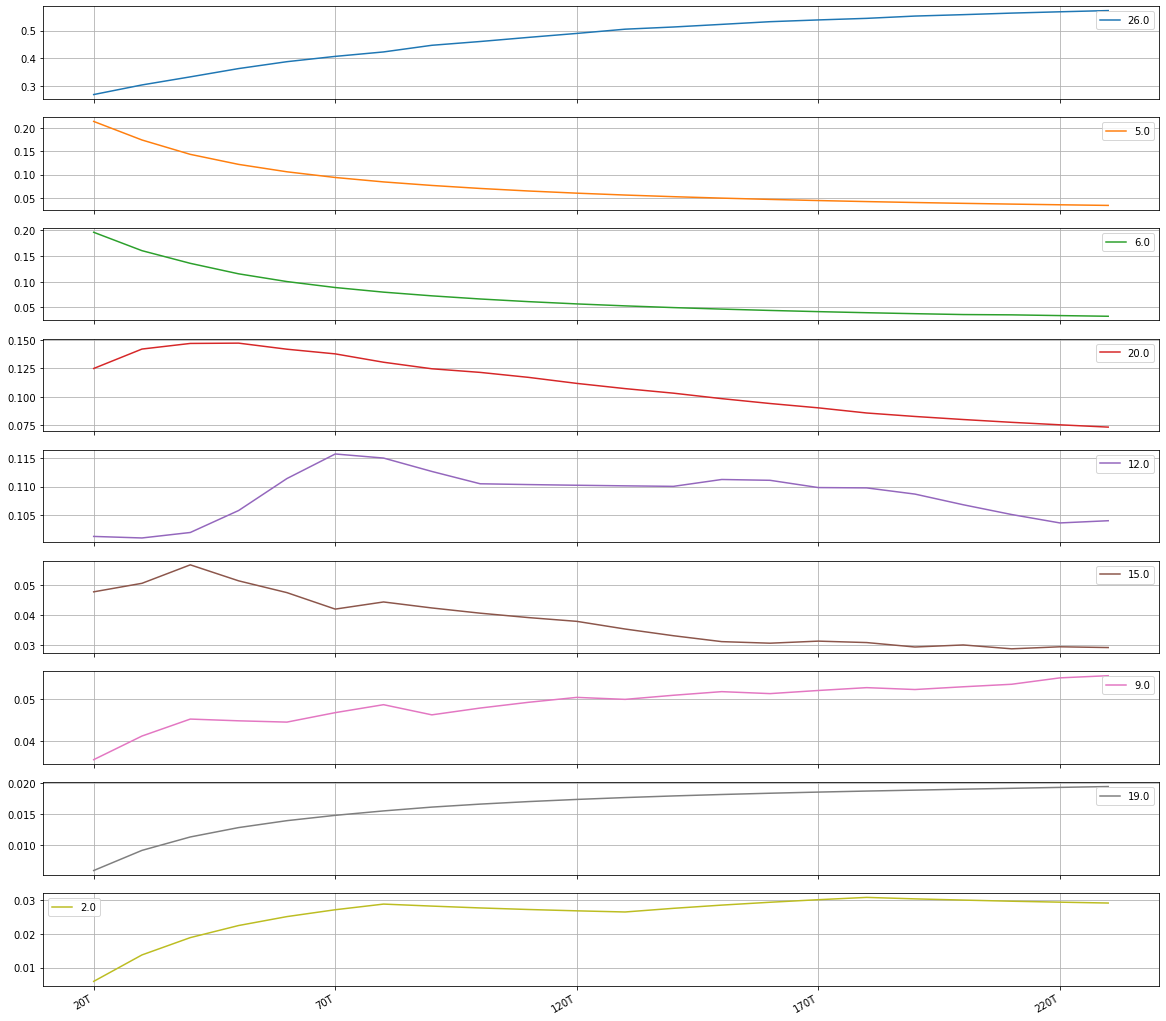

In [197]:
df_ = pd.DataFrame()
for k in cos_dist_dict.keys():
    df_anom = cos_dist_dict[k]['df_anom']
    vc = df_anom['cluster'].value_counts()/df_anom['cluster'].value_counts().sum()
    df_[k] = vc

df_.T.plot(subplots=True, figsize=(20,20), grid=True)
plt.show()

In [214]:
nb_clusters = list(df_.index[(df_.iloc[:,-1] - df_.iloc[:,1]) > 0])
nb_ratio = umap_df_iid['cluster'].value_counts()[nb_clusters].sum()/umap_df_iid['cluster'].value_counts().sum()
print(f'Normal behavior clusters: {nb_clusters}')
print(f'Turbine {TURBINE_ID} operates {"{:.2%}".format(nb_ratio)} of the time in a "normal" state.')

anom_clusters = list(set(df_.index).difference(set(nb_clusters)))
anom_ratio = umap_df_iid['cluster'].value_counts()[anom_clusters].sum()/umap_df_iid['cluster'].value_counts().sum()
print(f'Abnormal clusters: {anom_clusters}')
print(f'Turbine {TURBINE_ID} operates {"{:.2%}".format(anom_ratio)} of the time in an "abnormal" state.')

other_clusters = list(set(umap_df_iid['cluster'].unique()).difference(set(nb_clusters + anom_clusters)))
other_clusters = [x for x in other_clusters if str(x) != 'nan']

other_ratio = umap_df_iid['cluster'].value_counts()[other_clusters].sum()/umap_df_iid['cluster'].value_counts().sum()
print(f'Noisy clusters: {other_clusters}')
print(f'Turbine {TURBINE_ID} operates {"{:.2%}".format(other_ratio)} of the time in all other states.')

Normal behavior clusters: [26.0, 12.0, 9.0, 19.0, 2.0]
Turbine R80711 operates 83.71% of the time in a "normal" state.
Abnormal clusters: [20.0, 5.0, 6.0, 15.0]
Turbine R80711 operates 6.59% of the time in an "abnormal" state.
Noisy clusters: [0.0, 1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 13.0, 14.0, 16.0, 17.0, 18.0, 21.0, 22.0, 23.0, 24.0, 25.0]
Turbine R80711 operates 9.70% of the time in all other states.


### 5. Analyze relationship between missing data and the power curve

In this section, we're going to analyze the power curve. The power curve of a wind turbine is a graph that indicates how large the electrical power output will be for the turbine at different wind speeds. Based on the provided `Data description`, we're going to use `Ws_avg` (Average wind speed) and `P_avg` (Active power) to calculate the power curve.

In [95]:
def plot_flagged_pc(ws, p, flag_bool, alpha1, alpha2):
    plt.figure(figsize=(12,8))
    plt.grid()
    plt.scatter(ws, p, s = 1, alpha = alpha1)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red', alpha=alpha2)
    plt.title('Power Curve')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

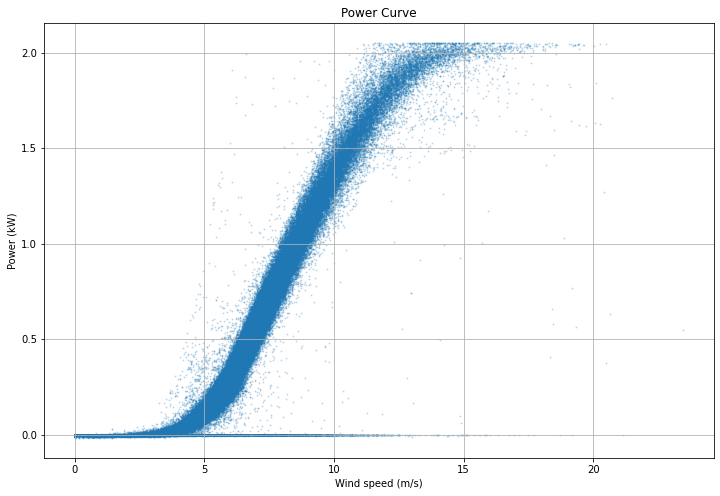

In [221]:
windspeed = df['Ws_avg']
power_kw = df['P_avg']/1000 # converts to kW 
plot_flagged_pc(windspeed, power_kw, np.repeat(True, df.shape[0]), .2, 0)

Now, we'll apply a window range filter to remove data with power values outside of the window below 20W for wind speeds above 5 m/s.

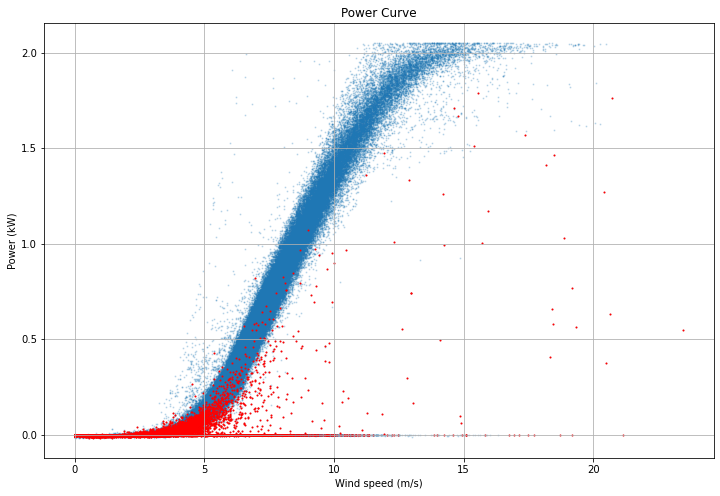

In [224]:
abnormal = [x in anom_clusters for x in umap_df_iid['cluster']]
plot_flagged_pc(windspeed, power_kw, abnormal, 0.2, 1)

Now that we have successfully tested the hypothesis and have some intuition on which clusters are associated with the `normal` and `anomaly` operating states, let's proceed to...

## 2. Grouping anomaly ranges.

First, let's rebuild the `UMAP` embeddings only for the non anomaly clusters:

In [227]:
norm_clusters = nb_clusters+other_clusters
norm_mask = [x in norm_clusters for x in umap_df_iid['cluster']]
norm_df = umap_df_iid.loc[norm_mask, :]
norm_df.head()

,emb-0,emb-1,cluster
Timestamp,,,
2012-12-31 23:00:00,6.853624,7.353701,26.0
2012-12-31 23:10:00,7.387391,6.361415,26.0
2012-12-31 23:20:00,7.767692,6.621686,26.0
2012-12-31 23:30:00,7.605279,6.376112,26.0
2012-12-31 23:40:00,7.362920,6.623297,26.0


In [228]:
norm_df['cluster'].unique()

array([26., 22., 12.,  8.,  0.,  9., 23., 13., 14.,  7., 25.,  4., 19.,
       17., 18., 16.,  2., 24., 21.,  3., 11.,  1., 10.])

Now, let's resample the `normal` states and visualize range with anomolies and missing values:

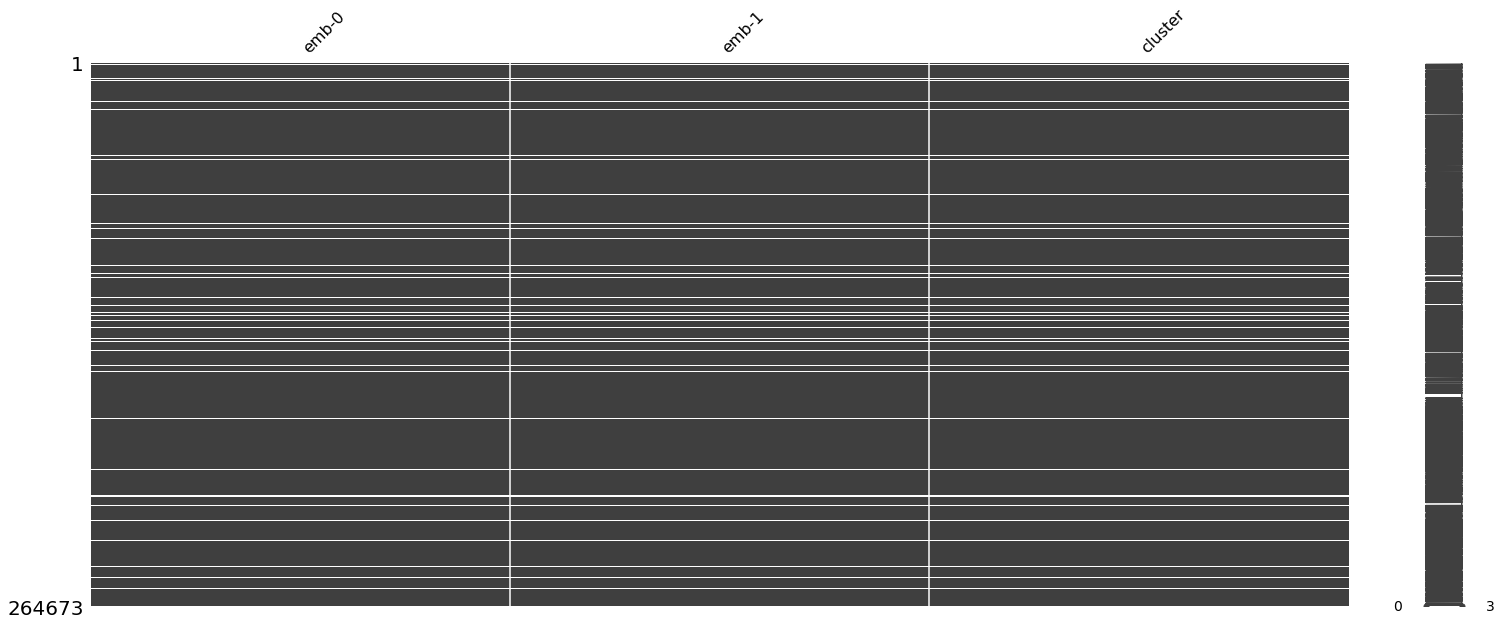

In [229]:
mn.matrix(norm_df.resample('10T').ffill(limit=1))
plt.show()

We can clearly see there is a lot of noise, i.e. there are a lot of `anomalies` that don't persist for very long. Let's split the data into consecutive sections and get the start and end times of each split:

In [230]:
def build_splits(df):
    df_ = df.resample('10T').ffill(limit=1).reset_index().dropna()
    norm_df_list = np.split(df_, np.flatnonzero(np.diff(df_.index) != 1) + 1)
    
    s = []
    e = []
    for df_ in norm_df_list:
        s.append(df_.iloc[0, 0])
        e.append(df_.iloc[-1, 0])

    split_df = pd.DataFrame(np.array([s,e]).T, columns = ['start', 'end'])
    split_df['duration'] = split_df['end'] - split_df['start']
    return split_df
split_df = build_splits(norm_df)
print(split_df.shape)
split_df.head()

(2057, 3)


,start,end,duration
0,2012-12-31 23:00:00,2013-01-07 07:50:00,6 days 08:50:00
1,2013-01-07 08:20:00,2013-01-07 08:30:00,0 days 00:10:00
2,2013-01-07 09:00:00,2013-01-07 20:40:00,0 days 11:40:00
3,2013-01-08 01:50:00,2013-01-08 03:00:00,0 days 01:10:00
4,2013-01-08 04:00:00,2013-01-08 06:10:00,0 days 02:10:00


Now, let's assume the **long splits** under `normal` operating state indicate that the underlying issue that caused the windturbine to fail has been **succesfully resolved**. 

And conversely, **short splits** under `normal` operating state indicate that the underlying issue has **NOT been fully resolved**.

In [232]:
duration_threashold = f'{12}H'
mask = split_df['duration'] >= pd.Timedelta(duration_threashold)
long_splits = split_df.loc[mask,:].reset_index(drop=True)
long_splits

,start,end,duration
0,2012-12-31 23:00:00,2013-01-07 07:50:00,6 days 08:50:00
1,2013-01-08 06:30:00,2013-01-09 06:30:00,1 days 00:00:00
2,2013-01-10 01:50:00,2013-01-14 09:00:00,4 days 07:10:00
3,2013-01-14 15:20:00,2013-01-16 14:00:00,1 days 22:40:00
4,2013-01-16 15:50:00,2013-01-17 11:20:00,0 days 19:30:00
...,...,...,...
834,2018-01-03 11:10:00,2018-01-05 09:20:00,1 days 22:10:00
835,2018-01-05 09:40:00,2018-01-06 05:00:00,0 days 19:20:00
836,2018-01-06 06:00:00,2018-01-09 04:40:00,2 days 22:40:00
837,2018-01-09 05:00:00,2018-01-11 08:40:00,2 days 03:40:00


Now, let's rebuild the data frame for the long splits: 

In [233]:
l = []
for split in long_splits.iterrows():
    s = split[1]['start']
    e = split[1]['end']
    l.append(umap_df.loc[s:e, :])
    
df_clean = pd.concat(l, axis=0)
df_clean.head()

,emb-0,emb-1
Timestamp,,
2012-12-31 23:00:00,8.267829,7.985660
2012-12-31 23:10:00,8.957531,6.955791
2012-12-31 23:20:00,9.647080,7.189283
2012-12-31 23:30:00,9.352875,7.052287
2012-12-31 23:40:00,8.743358,7.228366


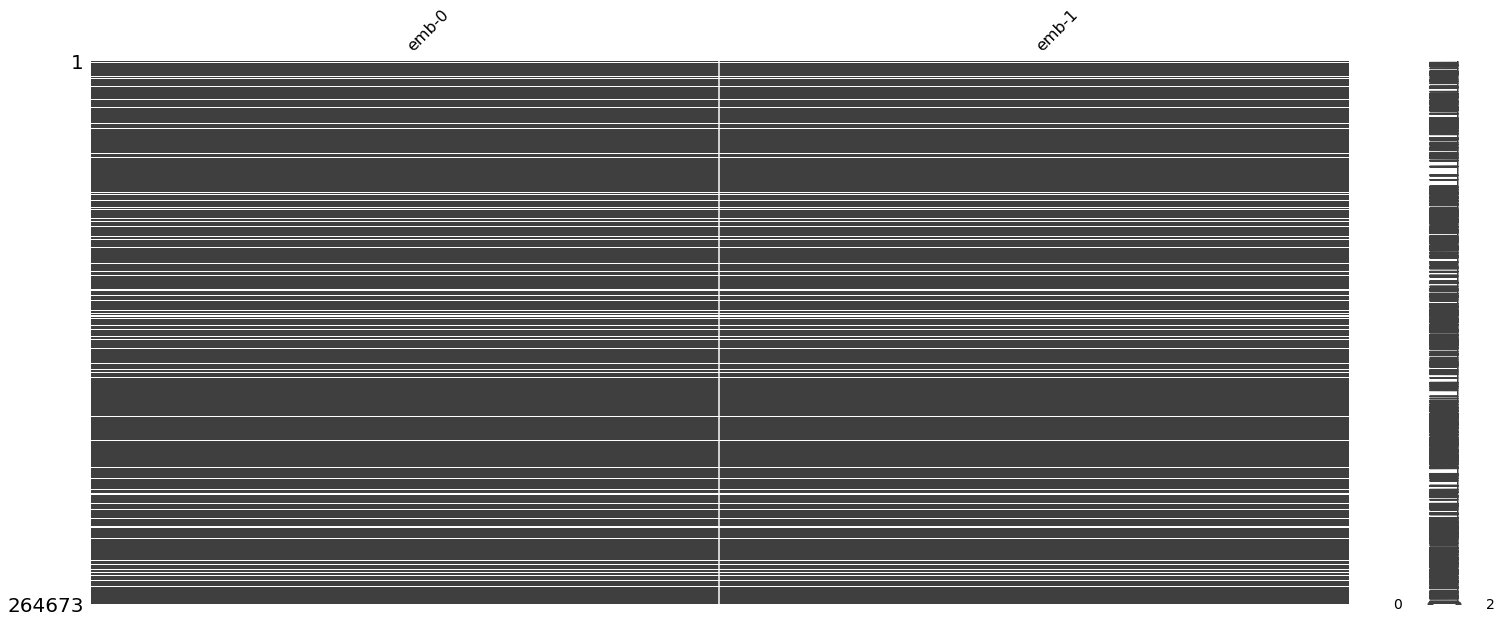

In [234]:
df_m = df_clean.resample('10T').ffill(limit=1)
mn.matrix(df_m)
plt.show()

In [235]:
print(f' Normal state makes up {"{:.2%}".format(df_clean.shape[0]/df_m.shape[0])} of the data.')

 Normal state makes up 89.06% of the data.


Finally, let's generate the anomaly labels:

In [236]:
def find_gaps(df):
    is_missing = df.resample('10T').ffill(limit=1).isna().all(axis=1)
    start_idx, end_idx = [], []
    for i, row in enumerate(np.array([is_missing[:-1], is_missing[1:]]).T):
        if row[0]==False and row[1]==True:
            start_idx.append(is_missing.index[i])
        elif row[0]==True and row[1]==False:
            end_idx.append(is_missing.index[i])
        else:
            pass

    miss_df = pd.DataFrame()
    miss_df['start'] = pd.to_datetime(start_idx)
    miss_df['end'] = pd.to_datetime(end_idx)
    # miss_df['duration'] = miss_df['end'] - miss_df['start'] 
    # miss_df['duration (min)'] = [x.seconds/(60) for x in miss_df['duration']]
    return miss_df

gaps_df = find_gaps(df_m)
print(gaps_df.shape)
gaps_df.head()

(617, 2)


,start,end
0,2013-01-07 08:00:00,2013-01-08 06:20:00
1,2013-01-09 06:40:00,2013-01-10 01:40:00
2,2013-01-14 09:10:00,2013-01-14 15:10:00
3,2013-01-16 14:10:00,2013-01-16 15:40:00
4,2013-01-17 11:30:00,2013-01-18 00:50:00


In [ ]:
gaps_df.to_csv(f'data/interim/{turbine}_labels.csv', header=None)